In [1]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import datetime
import math
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import seaborn as sns
import random
from PIL import Image
from io import BytesIO
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, f1_score
import warnings
warnings.filterwarnings('ignore')

# Inputlar ve Sabitler

In [2]:
DATASET_PATH = "/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake"
IMAGE_SIZE = (224, 224)
MAX_SAMPLES = 5000     # Her bir split için max alınacak toplam örnek sayısı
EPOCHS = 15            # 12 epoch yeterli oldu (önceki sonuçlara göre)  
BATCH_SIZE = 32        
BACKBONE = "convnext_base"  # En iyi sonucu veren backbone
USE_SPECTRAL = True      # Spektral analiz aktif
USE_ATTENTION = True     # Attention mekanizması aktif
USE_PROGRESSIVE_TRAINING = True  # Kademeli olarak katmanları çöz
USE_MIXUP = True         # Mixup data augmentation aktif
MIXUP_ALPHA = 0.2        # Mixup karıştırma oranı
CLIP_VALUE = 1.0         # Gradient clipping değeri
LEARNING_RATE = 1e-4     # Temel öğrenme hızı
MODEL_TIMESTAMP = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
MODEL_SAVE_PATH = f"deepfake_model_{MODEL_TIMESTAMP}.pth"  # Model kayıt dosya adı

# Veri Augmentasyonu

In [3]:
def jpeg_compression_simulator(image, quality_range=(50, 95)):
    """Farklı JPEG kalite seviyelerinde sıkıştırmayı simüle eder"""
    buffer = BytesIO()
    quality = random.randint(*quality_range)
    image.save(buffer, format="JPEG", quality=quality)
    buffer.seek(0)
    return Image.open(buffer)

In [4]:
def add_noise(image, noise_level=(0.01, 0.05)):
    """Görüntüye gürültü ekler"""
    img_np = np.array(image).astype(np.float32) / 255.0
    level = random.uniform(*noise_level)
    noise = np.random.normal(0, level, img_np.shape)
    noisy_img = np.clip(img_np + noise, 0, 1) * 255
    return Image.fromarray(noisy_img.astype(np.uint8))

In [5]:
def simulate_gan_artifacts(image):
    """GAN artifactlarını simüle eder"""
    img_np = np.array(image)
    # 8x8 blokları vurgula (GAN artifactları genellikle bu boyutta olur)
    h, w, c = img_np.shape
    for i in range(0, h, 8):
        for j in range(0, w, 8):
            if random.random() < 0.3:  # %30 olasılıkla bazı blokları daha belirgin yap
                for ch in range(c):
                    img_np[i:min(i+8, h), j:min(j+8, w), ch] = np.clip(
                        img_np[i:min(i+8, h), j:min(j+8, w), ch] * random.uniform(0.95, 1.05),
                        0, 255
                    )
    return Image.fromarray(img_np)


# Resim işleme

In [6]:
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(IMAGE_SIZE),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    # DeepFake'e özel transformlar
    transforms.Lambda(lambda img: jpeg_compression_simulator(img) if random.random() < 0.5 else img),
    transforms.Lambda(lambda img: add_noise(img) if random.random() < 0.3 else img),
    transforms.Lambda(lambda img: simulate_gan_artifacts(img) if random.random() < 0.4 else img),
    # Standart işlemler
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [7]:
# Validation/Test için sadece normalize işlemi
valid_test_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [8]:
def process_image(image_path, split):
    """
    Belirtilen split'e (train, valid, test) göre transform uygular.
    Train seti için augmentasyon, valid/test için sadece normalize işlemi yapılır.
    """
    transform_ops = train_transforms if split == 'train' else valid_test_transforms
    
    # Görüntüyü cv2 ile yükleme ve RGB'ye dönüştürme
    image_bgr = cv2.imread(image_path)
    if image_bgr is None:
        return None  # Dosya bozuk olabilir
    
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    image_tensor = transform_ops(image_rgb)
    return image_tensor

# Spectral Analiz Modülü

In [9]:
class AdvancedSpectralAnalyzer(nn.Module):
    """Gelişmiş spektral analiz modülü"""
    def __init__(self):
        super().__init__()
        
        # FFT Magnitude özellikleri için CNN
        self.magnitude_processor = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.GELU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.GELU(),
            nn.MaxPool2d(2, 2),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        
        # FFT Phase özellikleri için CNN
        self.phase_processor = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.GELU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.GELU(),
            nn.MaxPool2d(2, 2),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        
        # DCT özellikleri için CNN
        self.dct_processor = nn.Sequential(
            nn.Conv2d(48, 32, kernel_size=3, padding=1),  # 48 = 3*16 (3 kanal, 4x4 DCT katsayıları)
            nn.BatchNorm2d(32),
            nn.GELU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.GELU(),
            nn.MaxPool2d(2, 2),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        
        # Çıktı boyutu
        self.spectral_output_dim = 64 * 3  # 3 ayrı işleyici
    
    def _compute_dct_features(self, x):
        """DCT tabanlı özellikler hesaplar"""
        batch_size, channels, height, width = x.shape
        
        # Her kanal için DCT katsayılarını hesapla
        dct_features = []
        for c in range(channels):
            channel_features = []
            for i in range(0, height, 8):
                for j in range(0, width, 8):
                    # 8x8 blokları al
                    block = x[:, c, i:min(i+8, height), j:min(j+8, width)]
                    if block.shape[1] == 8 and block.shape[2] == 8:
                        # DCT hesapla (PyTorch FFT kullanarak)
                        dct_block = torch.fft.rfft2(block, norm='ortho')
                        
                        # Sadece düşük frekans bileşenlerini al (4x4)
                        low_freq = torch.abs(dct_block[:, :4, :4])
                        
                        # Yeniden şekillendir ve topla
                        channel_features.append(low_freq.view(batch_size, -1))
            
            if channel_features:
                # Tüm blokların ortalama özelliklerini al
                channel_dct = torch.stack(channel_features).mean(dim=0)
                dct_features.append(channel_dct)
        
        # Tüm kanallardan gelen DCT özelliklerini birleştir
        dct_concat = torch.cat(dct_features, dim=1)
        
        # DCT özellikleri için uygun tensor boyutunu oluştur
        dct_tensor = dct_concat.view(batch_size, channels, 4, 4)
        dct_tensor = dct_tensor.repeat(1, 16, 1, 1)  # 3*16=48 kanal
        
        return dct_tensor
    
    def forward(self, x):
        """
        Spektral analiz uygula
        x: (B, 3, H, W) formatında görüntü girişi
        """
        batch_size = x.shape[0]
        
        # 1. FFT Magnitude özellikleri
        fft_features = []
        for i in range(3):  # RGB kanalları
            channel = x[:, i, :, :]
            fft = torch.fft.fft2(channel)
            fft_shift = torch.fft.fftshift(fft)
            
            # Genlik spektrumu (logaritmik ölçekte)
            magnitude = torch.log(torch.abs(fft_shift) + 1e-10)
            
            # Normalize
            magnitude = (magnitude - magnitude.min()) / (magnitude.max() - magnitude.min() + 1e-10)
            fft_features.append(magnitude.unsqueeze(1))
        
        # 2. FFT Phase özellikleri
        phase_features = []
        for i in range(3):
            channel = x[:, i, :, :]
            fft = torch.fft.fft2(channel)
            fft_shift = torch.fft.fftshift(fft)
            
            # Faz spektrumu
            phase = torch.angle(fft_shift)
            
            # Normalize
            phase = (phase + math.pi) / (2 * math.pi)
            phase_features.append(phase.unsqueeze(1))
        
        # 3. DCT özellikleri
        dct_tensor = self._compute_dct_features(x)
        
        # Magnitude, Phase ve DCT özelliklerini işleyip birleştirme
        magnitude_tensor = torch.cat(fft_features, dim=1)  # (B, 3, H, W)
        phase_tensor = torch.cat(phase_features, dim=1)    # (B, 3, H, W)
        
        magnitude_features = self.magnitude_processor(magnitude_tensor).view(batch_size, -1)  # (B, 64)
        phase_features = self.phase_processor(phase_tensor).view(batch_size, -1)              # (B, 64)
        dct_features = self.dct_processor(dct_tensor).view(batch_size, -1)                    # (B, 64)
        
        # Tüm özellikleri birleştir
        return torch.cat([magnitude_features, phase_features, dct_features], dim=1)  # (B, 64*3)

# Veri Setinin Hazırlanması

In [10]:
def prepare_dataset(base_path, max_samples=None):
    """
    base_path altında train/valid/test klasörlerini arar. 
    Her birinde 'real' ve 'fake' alt klasörlerini okuyup 
    Tüm resimleri tensör haline getirir ve (data, labels) döndürür.
    max_samples => her split için max örnek (sınıflar dengeli olsun diye yarı yarıya).
    Örnek: max_samples=200 => 100 real, 100 fake.
    """
    datasets = {}
    
    for split in ['train', 'valid', 'test']:
        split_path = os.path.join(base_path, split)
        if not os.path.exists(split_path):
            print(f"'{split}' klasörü bulunamadı, atlanıyor...")
            continue
        
        print(f"\n=== {split.upper()} seti işleniyor... ===")
        data_list = []
        labels_list = []
        paths_list = []  # Görüntü yollarını da kaydedeceğiz (hata analizi için)
        
        for category in ['real', 'fake']:
            category_path = os.path.join(split_path, category)
            if not os.path.exists(category_path):
                continue
            
            label = 0 if category == 'real' else 1
            image_files = [f for f in os.listdir(category_path) 
                          if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            
            if max_samples:
                image_files = image_files[:max_samples // 2]
            
            print(f"{category.upper()} görüntüler yükleniyor... (seçilen {len(image_files)})")
            for filename in tqdm(image_files):
                image_path = os.path.join(category_path, filename)
                try:
                    tensor_img = process_image(image_path, split)
                    if tensor_img is not None:
                        data_list.append(tensor_img)
                        labels_list.append(label)
                        paths_list.append(image_path)
                except Exception as e:
                    print(f"Hata - {filename}: {str(e)}")
        
        if data_list:
            data_tensor = torch.stack(data_list)
            labels_tensor = torch.tensor(labels_list, dtype=torch.long)
            datasets[split] = (data_tensor, labels_tensor, paths_list)
            
            print(f"\n{split.upper()} seti istatistikleri:")
            print(f"Toplam işlenen görüntü: {len(data_tensor)}")
            print(f"Fake örnekler: {(labels_tensor == 1).sum().item()}")
            print(f"Real örnekler: {(labels_tensor == 0).sum().item()}")
        else:
            print(f"'{split}' için resim bulunamadı veya işlenemedi.")
    
    return datasets

# Özel Dataset Sınıfı

In [11]:
class DeepFakeDataset(Dataset):
    """PyTorch Dataset sınıfı"""
    def __init__(self, data, labels, image_paths):
        self.data = data
        self.labels = labels
        self.image_paths = image_paths
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx], self.image_paths[idx]

# CNN Katmanlarının Hazırlanması

In [12]:
def create_cnn_backbone(model_name="convnext_base", pretrained=True):
    """
    Farklı CNN mimarilerini oluşturur ve son katmanları çıkararak 
    feature extractor olarak döndürür.
    """
    if model_name == "resnet50":
        model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2 if pretrained else None)
        model = nn.Sequential(*list(model.children())[:-2])  # AvgPool ve FC hariç
        feat_dim = 2048
    elif model_name == "convnext_base":
        model = models.convnext_base(weights=models.ConvNeXt_Base_Weights.IMAGENET1K_V1 if pretrained else None)
        # ConvNeXt için farklı bir yol izlememiz gerekiyor
        features = model.features  # Bu, modelimizin konvolüsyon katmanlarını içerir
        model = nn.Sequential(*list(features.children()))
        feat_dim = 1024
    elif model_name == "efficientnet_v2_s":
        model = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.IMAGENET1K_V1 if pretrained else None)
        # EfficientNet için de farklı bir yol izliyoruz
        features = model.features
        model = nn.Sequential(*list(features.children()))
        feat_dim = 1280
    elif model_name == "swin_b":
        model = models.swin_b(weights=models.Swin_B_Weights.IMAGENET1K_V1 if pretrained else None)
        # Swin Transformer'ın yapısı da farklı
        features = nn.Sequential(
            model.features,
            model.norm,
            model.permute
        )
        model = features
        feat_dim = 1024
    else:
        raise ValueError(f"Desteklenmeyen model: {model_name}")
    
    return model, feat_dim

# Kademeli Fine-Tuning

In [13]:
def unfreeze_layers_progressively(model, backbone_name, epoch):
    """
    Eğitim sırasında backbone katmanlarını kademeli olarak çözer
    """
    # Başlangıçta tüm backbone'u dondur
    for name, param in model.named_parameters():
        if 'backbone' in name:
            param.requires_grad = False
    
    # Eğitim ilerledikçe, belirli katmanları çöz
    layers_to_unfreeze = []
    
    if backbone_name == "convnext_base":
        if epoch >= 5:
            # Son bloku çöz
            layers_to_unfreeze.append('backbone.7')
        if epoch >= 8:
            # Bir önceki bloku da çöz
            layers_to_unfreeze.append('backbone.6')
        if epoch >= 10:
            # Daha fazla blok çöz
            layers_to_unfreeze.append('backbone.5')
    elif backbone_name == "efficientnet_v2_s":
        if epoch >= 5:
            # Son birkaç katmanı çöz
            for i in range(7, 9):
                layers_to_unfreeze.append(f'backbone.{i}')
        if epoch >= 8:
            # Daha fazla katman çöz
            for i in range(5, 7):
                layers_to_unfreeze.append(f'backbone.{i}')
    elif backbone_name == "resnet50":
        if epoch >= 5:
            # Son layer4'ü çöz
            layers_to_unfreeze.append('backbone.layer4')
        if epoch >= 8:
            # layer3'ü de çöz
            layers_to_unfreeze.append('backbone.layer3')
    elif backbone_name == "swin_b":
        if epoch >= 5:
            # Son bloku çöz
            layers_to_unfreeze.append('backbone.features.7')
        if epoch >= 8:
            # Bir önceki bloku da çöz
            layers_to_unfreeze.append('backbone.features.6')
    
    # Belirtilen katmanları çöz
    for name, param in model.named_parameters():
        for layer_prefix in layers_to_unfreeze:
            if layer_prefix in name:
                param.requires_grad = True
    
    return model

# Attention Mekanizması

In [14]:
class EfficientAttention(nn.Module):
    """Daha verimli attention mekanizması"""
    def __init__(self, dim, num_heads=8, qkv_bias=False, attn_drop=0., proj_drop=0.):
        super().__init__()
        assert dim % num_heads == 0, 'dim should be divisible by num_heads'
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)

        # Scaled dot-product attention
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

In [15]:
class AttentionPooling(nn.Module):
    """Global özellikleri self-attention ile toplar"""
    def __init__(self, dim, num_heads=8, qkv_bias=False, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.attention = EfficientAttention(
            dim=dim,
            num_heads=num_heads,
            qkv_bias=qkv_bias,
            attn_drop=attn_drop,
            proj_drop=proj_drop
        )
        self.norm = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, dim * 4),
            nn.GELU(),
            nn.Dropout(proj_drop),
            nn.Linear(dim * 4, dim),
            nn.Dropout(proj_drop)
        )
        
    def forward(self, x):
        # x: [B, C, H, W] -> [B, H*W, C]
        B, C, H, W = x.shape
        x = x.flatten(2).permute(0, 2, 1)  # [B, H*W, C]
        
        # Self-Attention
        x = x + self.attention(self.norm(x))
        x = x + self.mlp(self.norm(x))
        
        # Global pooling
        x = x.mean(dim=1)  # [B, C]
        return x

# Gelişmiş Sınıflandırıcı

In [16]:
class ImprovedClassifier(nn.Module):
    """Gelişmiş sınıflandırıcı modülü"""
    def __init__(self, input_dim=2048, hidden_dim=512, output_dim=2):
        super().__init__()
        
        self.dropout1 = nn.Dropout(0.5)
        self.norm1 = nn.LayerNorm(input_dim)
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.activation1 = nn.GELU()
        
        self.dropout2 = nn.Dropout(0.3)
        self.norm2 = nn.LayerNorm(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.activation2 = nn.GELU()
        
        self.norm3 = nn.LayerNorm(hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, output_dim)
        
        # Weight normalization
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        # Normalizasyon ve regularizasyon
        x = self.norm1(x)
        x = self.dropout1(x)
        
        # İlk fully-connected katmanı
        x = self.fc1(x)
        x = self.activation1(x)
        
        # İkinci katman
        x = self.norm2(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        x = self.activation2(x)
        
        # Son katman
        x = self.norm3(x)
        x = self.fc3(x)
        
        return x

# Özellikle Füzyon Modülü

In [17]:
class FeatureFusionModule(nn.Module):
    """CNN ve FFT özelliklerini birleştirir"""
    def __init__(self, cnn_dim, fft_dim, output_dim):
        super().__init__()
        
        self.cnn_adapter = nn.Sequential(
            nn.Linear(cnn_dim, output_dim),
            nn.GELU(),
            nn.Dropout(0.3)
        )
        
        self.fft_adapter = nn.Sequential(
            nn.Linear(fft_dim, output_dim),
            nn.GELU(),
            nn.Dropout(0.3)
        )
        
        self.fusion = nn.Sequential(
            nn.Linear(output_dim * 2, output_dim),
            nn.GELU(),
            nn.Dropout(0.3)
        )
    
    def forward(self, cnn_features, fft_features):
        cnn_out = self.cnn_adapter(cnn_features)
        fft_out = self.fft_adapter(fft_features)
        
        # Özellik birleştirme
        fused = torch.cat([cnn_out, fft_out], dim=1)
        return self.fusion(fused)

# Deep fake Tespit Modeli

In [18]:
class HighPerformanceDeepFakeDetector(nn.Module):
    """Yüksek performanslı DeepFake tespit modeli"""
    def __init__(self, backbone_name="convnext_base", use_spectral=True, use_attention=True):
        super().__init__()
        
        # Backbone CNN
        self.backbone, self.backbone_dim = create_cnn_backbone(backbone_name)
        
        # Spektral analiz modülü
        self.use_spectral = use_spectral
        if use_spectral:
            self.spectral_analyzer = AdvancedSpectralAnalyzer()
            self.spectral_dim = self.spectral_analyzer.spectral_output_dim
        else:
            self.spectral_dim = 0
        
        # Attention pooling
        self.use_attention = use_attention
        if use_attention:
            self.attention = AttentionPooling(dim=self.backbone_dim)
        
        # Füzyon layer
        total_dim = self.backbone_dim + self.spectral_dim
        self.fusion = nn.Sequential(
            nn.Linear(total_dim, 1024),
            nn.LayerNorm(1024),
            nn.GELU(),
            nn.Dropout(0.3)
        )
        
        # Classifier
        self.classifier = ImprovedClassifier(input_dim=1024, hidden_dim=512, output_dim=2)
    
    def forward(self, x):
        # Backbone ile özellikleri çıkar
        features = self.backbone(x)
        
        # Global pooling (attention ya da normal)
        if self.use_attention:
            backbone_features = self.attention(features)
        else:
            backbone_features = torch.mean(features.view(features.size(0), features.size(1), -1), dim=2)
        
        # Spektral özellikler (opsiyonel)
        if self.use_spectral:
            spectral_features = self.spectral_analyzer(x)
            # Tüm özellikleri birleştir
            combined = torch.cat([backbone_features, spectral_features], dim=1)
        else:
            combined = backbone_features
        
        # Füzyon ve sınıflandırma
        fused = self.fusion(combined)
        output = self.classifier(fused)
        
        return output

# Mixup Data Augmentation

In [19]:
def mixup_data(x, y, alpha=0.2):
    """Mixup data augmentation uygula"""
    batch_size = x.size(0)
    if alpha > 0:
        # Beta dağılımından lambda örnekle
        lam = np.random.beta(alpha, alpha, batch_size)
        lam = torch.from_numpy(lam).float().to(x.device)
        lam = lam.view(-1, 1, 1, 1)  # Özellikler için yeniden şekillendir
        
        # Karıştırma için rastgele index
        index = torch.randperm(batch_size).to(x.device)
        mixed_x = lam * x + (1 - lam) * x[index]
        y_a, y_b = y, y[index]
        
        # Loss için lambda'yı scalar'a dönüştür
        lam = lam.squeeze()
        
        return mixed_x, y_a, y_b, lam
    return x, y, y, torch.ones(batch_size).to(x.device)

In [20]:
def mixup_criterion(criterion, pred, y_a, y_b, lam):
    """
    Mixup için loss hesapla - düzeltilmiş versiyon
    Her bir örnek için ayrı loss hesapla ve sonra ortalamasını al
    """
    # Her bir örnek için loss hesapla
    loss_a = criterion(pred, y_a)
    loss_b = criterion(pred, y_b)
    
    # Lambda tensor ise ortalamayı al
    if isinstance(lam, torch.Tensor) and lam.dim() > 0:
        return (lam.mean() * loss_a + (1 - lam.mean()) * loss_b)
    else:
        return lam * loss_a + (1 - lam) * loss_b

# Eğitim ve Değerlendirme Fonksiyonları

In [21]:
def train_step(model, data, labels, criterion, optimizer, device, use_mixup=False, mixup_alpha=0.2, clip_value=1.0):
    """Tek bir batch için eğitim adımı"""
    model.train()
    
    data, labels = data.to(device), labels.to(device)
    
    # Mixup kullan (opsiyonel)
    if use_mixup:
        mixed_data, labels_a, labels_b, lam = mixup_data(data, labels, alpha=mixup_alpha)
        
        # İleri geçiş (mixup data ile)
        outputs = model(mixed_data)
        loss = mixup_criterion(criterion, outputs, labels_a, labels_b, lam)
    else:
        # İleri geçiş (normal)
        outputs = model(data)
        loss = criterion(outputs, labels)
    
    # Geri yayılım
    optimizer.zero_grad()
    loss.backward()
    
    # Gradient clipping
    if clip_value > 0:
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
    
    optimizer.step()
    
    # Accuracy hesaplaması
    with torch.no_grad():
        if use_mixup:
            # Orijinal verileri kullanarak accuracy hesapla
            original_outputs = model(data)
            _, predicted = original_outputs.max(dim=1)
        else:
            _, predicted = outputs.max(dim=1)
            
        correct = predicted.eq(labels).sum().item()
    
    return loss.item(), correct

In [22]:
def validate_step(model, data_loader, criterion, device):
    """Validation veya test için değerlendirme adımı"""
    model.eval()
    
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for data, labels, _ in data_loader:
            data, labels = data.to(device), labels.to(device)
            
            # İleri geçiş
            outputs = model(data)
            loss = criterion(outputs, labels)
            
            # Metrikleri hesapla
            val_loss += loss.item() * labels.size(0)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = outputs.max(dim=1)
            val_correct += predicted.eq(labels).sum().item()
            val_total += labels.size(0)
            
            # Tüm tahminleri ve etiketleri topla
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())  # Fake sınıfı olasılıkları
    
    # Ortalama loss ve accuracy
    val_loss = val_loss / val_total
    val_acc = 100.0 * val_correct / val_total
    
    # ROC ve PR eğrileri için metrikler
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)
    
    precision, recall, _ = precision_recall_curve(all_labels, all_probs)
    pr_auc = average_precision_score(all_labels, all_probs)
    
    return val_loss, val_acc, roc_auc, pr_auc, all_preds, all_labels, all_probs

# Model Eğitimi

In [23]:
def train_model(epochs=15, batch_size=32, max_samples=5000, save_path=MODEL_SAVE_PATH):
    """
    Model eğitimi için ana fonksiyon. Eğitim ve değerlendirme adımlarını içerir.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Device: {device}")
    
    # Veri setlerini hazırla
    datasets = prepare_dataset(DATASET_PATH, max_samples=max_samples)
    if 'train' not in datasets or 'valid' not in datasets:
        print("Train veya valid seti bulunamadı, eğitim durduruldu.")
        return [], []
    
    train_data, train_labels, train_paths = datasets['train']
    valid_data, valid_labels, valid_paths = datasets['valid']
    
    # Dataset ve DataLoader objelerini oluştur
    train_dataset = DeepFakeDataset(train_data, train_labels, train_paths)
    valid_dataset = DeepFakeDataset(valid_data, valid_labels, valid_paths)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    
    # Modeli oluştur
    model = HighPerformanceDeepFakeDetector(
        backbone_name=BACKBONE,
        use_spectral=USE_SPECTRAL,
        use_attention=USE_ATTENTION
    ).to(device)
    
    # Kaç tane parametre var, görelim
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Toplam parametre sayısı: {total_params:,}")
    print(f"Eğitilebilir parametre sayısı: {trainable_params:,} ({trainable_params/total_params:.2%})")
    
    # Başlangıçta backbone'u dondur
    if USE_PROGRESSIVE_TRAINING:
        for name, param in model.named_parameters():
            if 'backbone' in name:
                param.requires_grad = False
                
        # Fine-tuning sonrası eğitilebilir parametreleri güncelle
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"Progressive eğitim aktif: Eğitilebilir parametreler: {trainable_params:,} ({trainable_params/total_params:.2%})")
    
    # Optimizer
    # Backbone için daha düşük learning rate
    backbone_params = [p for n, p in model.named_parameters() if 'backbone' in n and p.requires_grad]
    other_params = [p for n, p in model.named_parameters() if 'backbone' not in n and p.requires_grad]
    
    optimizer = torch.optim.AdamW([
        {'params': backbone_params, 'lr': LEARNING_RATE * 0.1, 'weight_decay': 1e-4},
        {'params': other_params, 'lr': LEARNING_RATE, 'weight_decay': 1e-4}
    ])
    
    # Learning Rate Scheduler - OneCycleLR (daha stabil)
    steps_per_epoch = len(train_loader)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=[LEARNING_RATE * 0.1, LEARNING_RATE],
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        pct_start=0.3,  # İlk %30'unda artan, sonra azalan lr
        div_factor=25,
        final_div_factor=1e4
    )
    
    # Loss
    criterion = nn.CrossEntropyLoss()
    
    # Eğitim takibi için metrikler
    best_valid_acc = 0.0
    train_losses, valid_losses = [], []
    train_accs, valid_accs = [], []
    valid_aucs, valid_praucs = [], []
    
    # Early stopping için
    patience = 5
    no_improvement_count = 0
    
    for epoch in range(epochs):
        # -------------------------
        # Kademeli Fine-Tuning
        # -------------------------
        if USE_PROGRESSIVE_TRAINING and epoch > 0:
            model = unfreeze_layers_progressively(model, BACKBONE, epoch)
            # Fine-tuning sonrası eğitilebilir parametreleri güncelle
            trainable_params_new = sum(p.numel() for p in model.parameters() if p.requires_grad)
            print(f"Epoch {epoch+1}: Eğitilebilir parametreler: {trainable_params_new:,} ({trainable_params_new/total_params:.2%})")
        
        # -------------------------
        # TRAIN
        # -------------------------
        model.train()
        epoch_train_loss = 0.0
        epoch_train_correct = 0
        epoch_train_total = 0
        
        for data, labels, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Training"):
            data, labels = data.to(device), labels.to(device)
            
            # İleri geçiş (Mixup ile veya normal)
            loss, correct = train_step(
                model, data, labels, criterion, optimizer, device, 
                use_mixup=USE_MIXUP, mixup_alpha=MIXUP_ALPHA, clip_value=CLIP_VALUE
            )
            
            # Metrikleri güncelle
            epoch_train_loss += loss * labels.size(0)
            epoch_train_correct += correct
            epoch_train_total += labels.size(0)
            
            # Learning rate güncelleme (batch başına)
            scheduler.step()
        
        # Epoch metriklerini hesapla
        train_loss = epoch_train_loss / epoch_train_total
        train_acc = 100.0 * epoch_train_correct / epoch_train_total
        
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        # -------------------------
        # VALID
        # -------------------------
        valid_loss, valid_acc, roc_auc, pr_auc, _, _, _ = validate_step(
            model, valid_loader, criterion, device
        )
        
        valid_losses.append(valid_loss)
        valid_accs.append(valid_acc)
        valid_aucs.append(roc_auc)
        valid_praucs.append(pr_auc)
        
        # Metrikleri yazdır
        print(f"\nEpoch {epoch+1}/{epochs}:")
        print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"  Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.2f}%")
        print(f"  ROC AUC: {roc_auc:.4f}, PR AUC: {pr_auc:.4f}")
        print(f"  Current LR: {scheduler.get_last_lr()[1]:.2e}")
        
        # En iyi modeli kaydet
        if valid_acc > best_valid_acc:
            best_valid_acc = valid_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'valid_acc': valid_acc,
                'roc_auc': roc_auc,
                'config': {
                    'backbone': BACKBONE,
                    'use_spectral': USE_SPECTRAL,
                    'use_attention': USE_ATTENTION
                }
            }, save_path)
            print(f"  ---> Yeni en iyi valid acc: {best_valid_acc:.2f}%, model kaydedildi: {save_path}")
            no_improvement_count = 0
        else:
            no_improvement_count += 1
            print(f"  ---> No improvement for {no_improvement_count} epochs.")
        
        # Early stopping kontrolü
        if no_improvement_count >= patience:
            print(f"\nEarly Stopping tetiklendi! {patience} epoch boyunca iyileşme gözlenmedi.")
            break
    
    # Eğitim sonuçlarını görselleştir
    plot_training_results(train_losses, valid_losses, train_accs, valid_accs, valid_aucs, valid_praucs)
    
    return train_losses, valid_losses, train_accs, valid_accs, valid_aucs, valid_praucs
    

In [25]:
def plot_training_results(train_losses, valid_losses, train_accs, valid_accs, valid_aucs, valid_praucs):
    """Eğitim sonuçlarını görselleştirir"""
    plt.figure(figsize=(16, 10))
    
    # Loss grafiği
    plt.subplot(2, 2, 1)
    plt.plot(train_losses, 'b-', label='Train Loss')
    plt.plot(valid_losses, 'r-', label='Valid Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training & Validation Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Accuracy grafiği
    plt.subplot(2, 2, 2)
    plt.plot(train_accs, 'b-', label='Train Accuracy')
    plt.plot(valid_accs, 'r-', label='Valid Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training & Validation Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # ROC AUC grafiği
    plt.subplot(2, 2, 3)
    plt.plot(valid_aucs, 'g-', label='ROC AUC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.title('Validation ROC AUC')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # PR AUC grafiği
    plt.subplot(2, 2, 4)
    plt.plot(valid_praucs, 'm-', label='PR AUC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.title('Validation PR AUC')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('training_metrics.png')
    plt.show()

# Model Yükleme ve Test Etme

In [26]:
def load_model(model_path=MODEL_SAVE_PATH):
    """Kaydedilen modeli yükler"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Model checkpoint'i yükle
    checkpoint = torch.load(model_path, map_location=device)
    
    # Model konfigürasyonunu al
    config = checkpoint.get('config', {
        'backbone': BACKBONE,
        'use_spectral': USE_SPECTRAL,
        'use_attention': USE_ATTENTION
    })
    
    # Modeli oluştur ve ağırlıkları yükle
    model = HighPerformanceDeepFakeDetector(
        backbone_name=config['backbone'],
        use_spectral=config['use_spectral'],
        use_attention=config.get('use_attention', USE_ATTENTION)
    ).to(device)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    print(f"Model başarıyla yüklendi. En iyi doğruluk: {checkpoint.get('valid_acc', 0):.2f}%")
    return model, device

In [27]:
def test_saved_model(image_path, model_path=MODEL_SAVE_PATH):
    """Tek bir resim üzerinde tahmin yapar"""
    model, device = load_model(model_path)
    
    # Resmi yükle ve işle
    image_bgr = cv2.imread(image_path)
    if image_bgr is None:
        print(f"Resim yüklenemedi: {image_path}")
        return None
    
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    transform_ops = valid_test_transforms
    image_tensor = transform_ops(image_rgb).unsqueeze(0).to(device)
    
    # Tahmin yap
    with torch.no_grad():
        outputs = model(image_tensor)
        probs = torch.softmax(outputs, dim=1).cpu().numpy()[0]
    
    # Sonuçları yazdır
    pred_label = "Fake" if probs[1] > 0.5 else "Real"
    print(f"Tahmin Olasılıkları -> Real={probs[0]:.4f}, Fake={probs[1]:.4f}")
    print(f"Tahmin Etiketi: {pred_label}")
    
    # Görüntüyü göster ve sonucu görselleştir
    visualize_prediction(model, image_rgb, probs, pred_label)
    
    return probs

In [28]:
def visualize_prediction(model, image, probs, pred_label):
    """Tahmin sonucunu görselleştirir"""
    plt.figure(figsize=(10, 6))
    
    # Orijinal görüntü
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f"Tahmin: {pred_label}\nReal: {probs[0]:.2%}, Fake: {probs[1]:.2%}")
    plt.axis('off')
    
    # Olasılık çubuğu
    plt.subplot(1, 2, 2)
    labels = ['Real', 'Fake']
    colors = ['green', 'red']
    plt.barh(labels, probs, color=colors)
    plt.xlim(0, 1)
    for i, p in enumerate(probs):
        plt.text(p + 0.01, i, f"{p:.2%}", va='center')
    plt.title("Tahmin Olasılıkları")
    
    plt.tight_layout()
    plt.show()

# Gelişmiş Değerlendirme

In [29]:
def advanced_evaluation(model, test_loader, device):
    """Gelişmiş model değerlendirmesi yapar"""
    model.eval()
    
    all_preds = []
    all_labels = []
    all_probs = []
    all_losses = []
    image_paths = []
    
    criterion = nn.CrossEntropyLoss(reduction='none')  # Her örnek için ayrı loss
    
    with torch.no_grad():
        for data, labels, paths in tqdm(test_loader, desc="Evaluating"):
            data, labels = data.to(device), labels.to(device)
            
            # İleri geçiş
            outputs = model(data)
            losses = criterion(outputs, labels)
            
            # Olasılıklar ve tahminler
            probs = torch.softmax(outputs, dim=1)
            _, predicted = outputs.max(dim=1)
            
            # Sonuçları topla
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())  # Fake sınıfı olasılıkları
            all_losses.extend(losses.cpu().numpy())
            image_paths.extend(paths)
    
    # Temel metrikler
    accuracy = accuracy_score(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, target_names=["Real", "Fake"])
    
    # ROC ve Precision-Recall eğrileri
    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)
    
    precision, recall, pr_thresholds = precision_recall_curve(all_labels, all_probs)
    pr_auc = average_precision_score(all_labels, all_probs)
    
    # En iyi eşik değeri hesapla (F1 skoruna göre)
    f1_scores = []
    for threshold in thresholds:
        preds = [1 if p > threshold else 0 for p in all_probs]
        f1 = f1_score(all_labels, preds)
        f1_scores.append(f1)
    
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]
    best_f1 = f1_scores[best_idx]
    
    # Sonuçları yazdır
    print("\n===== TEST SONUÇLARI =====")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"PR AUC: {pr_auc:.4f}")
    print(f"En iyi F1 skoru: {best_f1:.4f} (threshold={best_threshold:.4f})")
    print("\nClassification Report:")
    print(report)
    
    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
               xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
    plt.xlabel("Tahmin")
    plt.ylabel("Gerçek")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    plt.show()
    
    # ROC ve PR eğrileri
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve (AUC = {roc_auc:.4f})')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve (AP = {pr_auc:.4f})')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('roc_pr_curves.png')
    plt.show()
    
    # Hata analizi için veri hazırla
    error_data = []
    for i in range(len(all_labels)):
        if all_preds[i] != all_labels[i]:
            error_data.append({
                "path": image_paths[i],
                "true": all_labels[i],
                "pred": all_preds[i],
                "prob": all_probs[i],
                "loss": all_losses[i]
            })
    
    # En yüksek loss'a sahip hatalı örnekleri bul
    error_data.sort(key=lambda x: x["loss"], reverse=True)
    
    # Hata analizi
    error_analysis(error_data)
    
    return {
        "accuracy": accuracy,
        "report": report,
        "roc_auc": roc_auc,
        "pr_auc": pr_auc,
        "best_threshold": best_threshold,
        "best_f1": best_f1,
        "error_data": error_data
    }

# Hata Analizi

In [30]:
def error_analysis(error_data, num_examples=10):
    """Modelin hatalı tahminlerini analiz eder ve görselleştirir"""
    # En kötü tahminleri göster
    worst_errors = error_data[:num_examples]
    
    # Görselleştirme
    fig, axs = plt.subplots(2, 5, figsize=(20, 8))
    axs = axs.flatten()
    
    for i, err in enumerate(worst_errors):
        if i >= len(axs):
            break
            
        # Görüntüyü yükle
        img = cv2.imread(err["path"])
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # Görüntüyü göster
            axs[i].imshow(img)
            true_label = "Real" if err["true"] == 0 else "Fake"
            pred_label = "Real" if err["pred"] == 0 else "Fake"
            axs[i].set_title(f"True: {true_label}\nPred: {pred_label}\nProb: {err['prob']:.3f}")
            axs[i].axis('off')
    
    plt.tight_layout()
    plt.savefig('error_analysis.png')
    plt.show()
    
    # Hata istatistikleri
    fp_count = sum(1 for err in error_data if err["true"] == 0 and err["pred"] == 1)
    fn_count = sum(1 for err in error_data if err["true"] == 1 and err["pred"] == 0)
    
    print("\n===== HATA ANALİZİ =====")
    print(f"Toplam hata sayısı: {len(error_data)}")
    print(f"Gerçek -> Sahte (False Positive): {fp_count} ({fp_count/len(error_data):.2%})")
    print(f"Sahte -> Gerçek (False Negative): {fn_count} ({fn_count/len(error_data):.2%})")

# Test Model

In [31]:
def test_model(model_path=None):
    """Test setinde model değerlendirmesi yapar"""
    print("\nTest seti üzerinde değerlendirme yapılıyor...")
    datasets = prepare_dataset(DATASET_PATH, max_samples=MAX_SAMPLES)
    
    if 'test' in datasets:
        test_data, test_labels, test_paths = datasets['test']
        test_dataset = DeepFakeDataset(test_data, test_labels, test_paths)
        test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
        
        # Modeli yükle - ya belirtilen path ya da global MODEL_SAVE_PATH kullan
        if model_path is None:
            model_path = MODEL_SAVE_PATH
            
        model, device = load_model(model_path)
        
        # Kapsamlı değerlendirme
        results = advanced_evaluation(model, test_loader, device)
        
        # Bazı örnek görüntüler için tahmin yap
        if test_paths:
            print("\nÖrnek tahminler yapılıyor...")
            for i in range(min(5, len(test_paths))):
                test_saved_model(test_paths[i], model_path)
        
        return results
    else:
        print("Test seti bulunamadı.")
        return None

# Ana Çalışma Akışı

Yüksek Performanslı DeepFake Tespit Modeli Eğitimi
Konfigürasyon:
  Dataset: /kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake
  Max Samples: 5000
  Backbone: convnext_base
  Spektral Analiz: Aktif
  Attention Mekanizması: Aktif
  Kademeli Eğitim: Aktif
  Mixup Augmentation: Aktif
  Learning Rate: 0.0001
  Model Dosyası: deepfake_model_20250228_140749.pth

Modeli eğitmeye başlıyorum...
Device: cuda

=== TRAIN seti işleniyor... ===
REAL görüntüler yükleniyor... (seçilen 2500)


100%|██████████| 2500/2500 [00:43<00:00, 57.98it/s]


FAKE görüntüler yükleniyor... (seçilen 2500)


100%|██████████| 2500/2500 [00:41<00:00, 59.77it/s]



TRAIN seti istatistikleri:
Toplam işlenen görüntü: 5000
Fake örnekler: 2500
Real örnekler: 2500

=== VALID seti işleniyor... ===
REAL görüntüler yükleniyor... (seçilen 2500)


100%|██████████| 2500/2500 [00:23<00:00, 106.05it/s]


FAKE görüntüler yükleniyor... (seçilen 2500)


100%|██████████| 2500/2500 [00:24<00:00, 101.85it/s]



VALID seti istatistikleri:
Toplam işlenen görüntü: 5000
Fake örnekler: 2500
Real örnekler: 2500

=== TEST seti işleniyor... ===
REAL görüntüler yükleniyor... (seçilen 2500)


100%|██████████| 2500/2500 [00:27<00:00, 92.12it/s]


FAKE görüntüler yükleniyor... (seçilen 2500)


100%|██████████| 2500/2500 [00:28<00:00, 87.29it/s]



TEST seti istatistikleri:
Toplam işlenen görüntü: 5000
Fake örnekler: 2500
Real örnekler: 2500


Downloading: "https://download.pytorch.org/models/convnext_base-6075fbad.pth" to /root/.cache/torch/hub/checkpoints/convnext_base-6075fbad.pth
100%|██████████| 338M/338M [00:01<00:00, 226MB/s]  


Toplam parametre sayısı: 102,135,714
Eğitilebilir parametre sayısı: 102,135,714 (100.00%)
Progressive eğitim aktif: Eğitilebilir parametreler: 14,571,298 (14.27%)


Epoch 1/15 - Training: 100%|██████████| 157/157 [02:41<00:00,  1.03s/it]



Epoch 1/15:
  Train Loss: 7.4840, Train Acc: 53.42%
  Valid Loss: 2.3669, Valid Acc: 61.98%
  ROC AUC: 0.6684, PR AUC: 0.6420
  Current LR: 1.53e-05
  ---> Yeni en iyi valid acc: 61.98%, model kaydedildi: deepfake_model_20250228_140749.pth
Epoch 2: Eğitilebilir parametreler: 14,571,298 (14.27%)


Epoch 2/15 - Training: 100%|██████████| 157/157 [02:38<00:00,  1.01s/it]



Epoch 2/15:
  Train Loss: 5.0485, Train Acc: 52.20%
  Valid Loss: 2.1133, Valid Acc: 53.88%
  ROC AUC: 0.6388, PR AUC: 0.6100
  Current LR: 4.38e-05
  ---> No improvement for 1 epochs.
Epoch 3: Eğitilebilir parametreler: 14,571,298 (14.27%)


Epoch 3/15 - Training: 100%|██████████| 157/157 [02:38<00:00,  1.01s/it]



Epoch 3/15:
  Train Loss: 2.9857, Train Acc: 52.98%
  Valid Loss: 0.6529, Valid Acc: 62.60%
  ROC AUC: 0.6970, PR AUC: 0.6848
  Current LR: 7.61e-05
  ---> Yeni en iyi valid acc: 62.60%, model kaydedildi: deepfake_model_20250228_140749.pth
Epoch 4: Eğitilebilir parametreler: 14,571,298 (14.27%)


Epoch 4/15 - Training: 100%|██████████| 157/157 [02:37<00:00,  1.00s/it]



Epoch 4/15:
  Train Loss: 1.5653, Train Acc: 52.94%
  Valid Loss: 0.6693, Valid Acc: 52.70%
  ROC AUC: 0.7631, PR AUC: 0.7545
  Current LR: 9.72e-05
  ---> No improvement for 1 epochs.
Epoch 5: Eğitilebilir parametreler: 14,571,298 (14.27%)


Epoch 5/15 - Training: 100%|██████████| 157/157 [02:38<00:00,  1.01s/it]



Epoch 5/15:
  Train Loss: 0.9876, Train Acc: 55.02%
  Valid Loss: 0.5910, Valid Acc: 69.68%
  ROC AUC: 0.8065, PR AUC: 0.7934
  Current LR: 9.94e-05
  ---> Yeni en iyi valid acc: 69.68%, model kaydedildi: deepfake_model_20250228_140749.pth
Epoch 6: Eğitilebilir parametreler: 39,915,298 (39.08%)


Epoch 6/15 - Training: 100%|██████████| 157/157 [02:48<00:00,  1.07s/it]



Epoch 6/15:
  Train Loss: 0.8163, Train Acc: 61.08%
  Valid Loss: 0.6317, Valid Acc: 53.18%
  ROC AUC: 0.8453, PR AUC: 0.8364
  Current LR: 9.50e-05
  ---> No improvement for 1 epochs.
Epoch 7: Eğitilebilir parametreler: 39,915,298 (39.08%)


Epoch 7/15 - Training: 100%|██████████| 157/157 [02:47<00:00,  1.07s/it]



Epoch 7/15:
  Train Loss: 0.7496, Train Acc: 63.72%
  Valid Loss: 0.5343, Valid Acc: 77.12%
  ROC AUC: 0.8587, PR AUC: 0.8510
  Current LR: 8.66e-05
  ---> Yeni en iyi valid acc: 77.12%, model kaydedildi: deepfake_model_20250228_140749.pth
Epoch 8: Eğitilebilir parametreler: 39,915,298 (39.08%)


Epoch 8/15 - Training: 100%|██████████| 157/157 [02:47<00:00,  1.07s/it]



Epoch 8/15:
  Train Loss: 0.7101, Train Acc: 68.94%
  Valid Loss: 0.4950, Valid Acc: 81.90%
  ROC AUC: 0.8974, PR AUC: 0.8920
  Current LR: 7.49e-05
  ---> Yeni en iyi valid acc: 81.90%, model kaydedildi: deepfake_model_20250228_140749.pth
Epoch 9: Eğitilebilir parametreler: 42,014,498 (41.14%)


Epoch 9/15 - Training: 100%|██████████| 157/157 [02:50<00:00,  1.09s/it]



Epoch 9/15:
  Train Loss: 0.6827, Train Acc: 72.40%
  Valid Loss: 0.4702, Valid Acc: 81.86%
  ROC AUC: 0.9065, PR AUC: 0.8993
  Current LR: 6.10e-05
  ---> No improvement for 1 epochs.
Epoch 10: Eğitilebilir parametreler: 42,014,498 (41.14%)


Epoch 10/15 - Training: 100%|██████████| 157/157 [02:51<00:00,  1.09s/it]



Epoch 10/15:
  Train Loss: 0.6679, Train Acc: 75.22%
  Valid Loss: 0.4461, Valid Acc: 84.30%
  ROC AUC: 0.9275, PR AUC: 0.9235
  Current LR: 4.62e-05
  ---> Yeni en iyi valid acc: 84.30%, model kaydedildi: deepfake_model_20250228_140749.pth
Epoch 11: Eğitilebilir parametreler: 99,439,394 (97.36%)


Epoch 11/15 - Training: 100%|██████████| 157/157 [04:34<00:00,  1.75s/it]



Epoch 11/15:
  Train Loss: 0.6599, Train Acc: 77.60%
  Valid Loss: 0.4492, Valid Acc: 85.36%
  ROC AUC: 0.9343, PR AUC: 0.9322
  Current LR: 3.16e-05
  ---> Yeni en iyi valid acc: 85.36%, model kaydedildi: deepfake_model_20250228_140749.pth
Epoch 12: Eğitilebilir parametreler: 99,439,394 (97.36%)


Epoch 12/15 - Training: 100%|██████████| 157/157 [04:34<00:00,  1.75s/it]



Epoch 12/15:
  Train Loss: 0.6448, Train Acc: 79.10%
  Valid Loss: 0.4171, Valid Acc: 86.66%
  ROC AUC: 0.9400, PR AUC: 0.9382
  Current LR: 1.88e-05
  ---> Yeni en iyi valid acc: 86.66%, model kaydedildi: deepfake_model_20250228_140749.pth
Epoch 13: Eğitilebilir parametreler: 99,439,394 (97.36%)


Epoch 13/15 - Training: 100%|██████████| 157/157 [04:34<00:00,  1.75s/it]



Epoch 13/15:
  Train Loss: 0.6419, Train Acc: 80.64%
  Valid Loss: 0.4108, Valid Acc: 87.10%
  ROC AUC: 0.9446, PR AUC: 0.9428
  Current LR: 8.63e-06
  ---> Yeni en iyi valid acc: 87.10%, model kaydedildi: deepfake_model_20250228_140749.pth
Epoch 14: Eğitilebilir parametreler: 99,439,394 (97.36%)


Epoch 14/15 - Training: 100%|██████████| 157/157 [04:34<00:00,  1.75s/it]



Epoch 14/15:
  Train Loss: 0.6450, Train Acc: 81.26%
  Valid Loss: 0.4081, Valid Acc: 86.94%
  ROC AUC: 0.9443, PR AUC: 0.9424
  Current LR: 2.19e-06
  ---> No improvement for 1 epochs.
Epoch 15: Eğitilebilir parametreler: 99,439,394 (97.36%)


Epoch 15/15 - Training: 100%|██████████| 157/157 [04:35<00:00,  1.75s/it]



Epoch 15/15:
  Train Loss: 0.6391, Train Acc: 81.74%
  Valid Loss: 0.4070, Valid Acc: 87.08%
  ROC AUC: 0.9447, PR AUC: 0.9429
  Current LR: 4.91e-10
  ---> No improvement for 2 epochs.


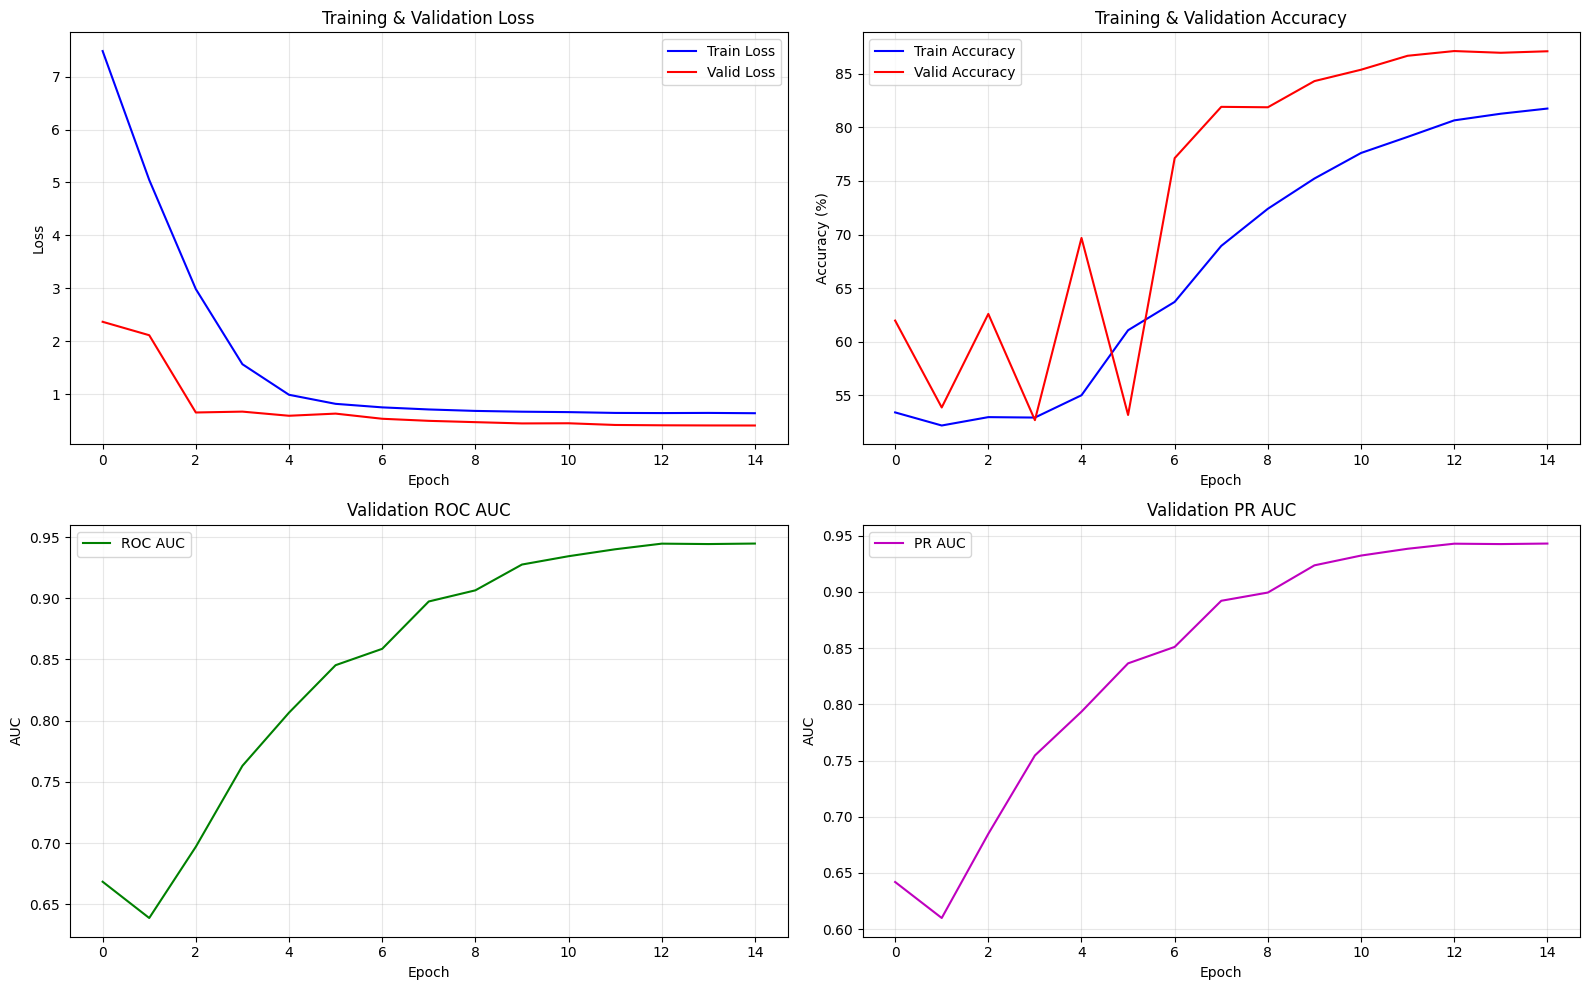


Test seti üzerinde değerlendirme yapılıyor...

=== TRAIN seti işleniyor... ===
REAL görüntüler yükleniyor... (seçilen 2500)


100%|██████████| 2500/2500 [00:25<00:00, 98.62it/s] 


FAKE görüntüler yükleniyor... (seçilen 2500)


100%|██████████| 2500/2500 [00:25<00:00, 97.88it/s] 



TRAIN seti istatistikleri:
Toplam işlenen görüntü: 5000
Fake örnekler: 2500
Real örnekler: 2500

=== VALID seti işleniyor... ===
REAL görüntüler yükleniyor... (seçilen 2500)


100%|██████████| 2500/2500 [00:07<00:00, 318.95it/s]


FAKE görüntüler yükleniyor... (seçilen 2500)


100%|██████████| 2500/2500 [00:08<00:00, 304.43it/s]



VALID seti istatistikleri:
Toplam işlenen görüntü: 5000
Fake örnekler: 2500
Real örnekler: 2500

=== TEST seti işleniyor... ===
REAL görüntüler yükleniyor... (seçilen 2500)


100%|██████████| 2500/2500 [00:10<00:00, 237.97it/s]


FAKE görüntüler yükleniyor... (seçilen 2500)


100%|██████████| 2500/2500 [00:11<00:00, 226.50it/s]



TEST seti istatistikleri:
Toplam işlenen görüntü: 5000
Fake örnekler: 2500
Real örnekler: 2500
Model başarıyla yüklendi. En iyi doğruluk: 87.10%


Evaluating: 100%|██████████| 157/157 [01:15<00:00,  2.09it/s]



===== TEST SONUÇLARI =====
Test Accuracy: 0.8794
ROC AUC: 0.9476
PR AUC: 0.9466
En iyi F1 skoru: 0.8827 (threshold=0.4743)

Classification Report:
              precision    recall  f1-score   support

        Real       0.88      0.88      0.88      2500
        Fake       0.88      0.88      0.88      2500

    accuracy                           0.88      5000
   macro avg       0.88      0.88      0.88      5000
weighted avg       0.88      0.88      0.88      5000



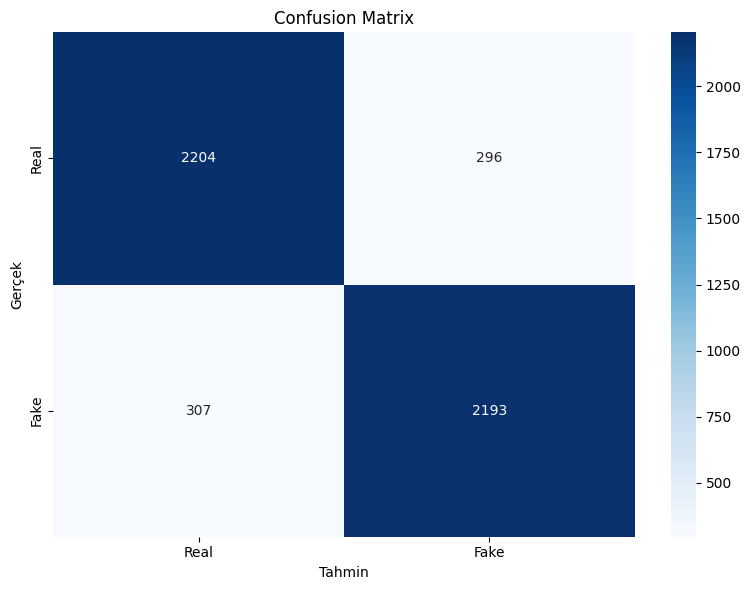

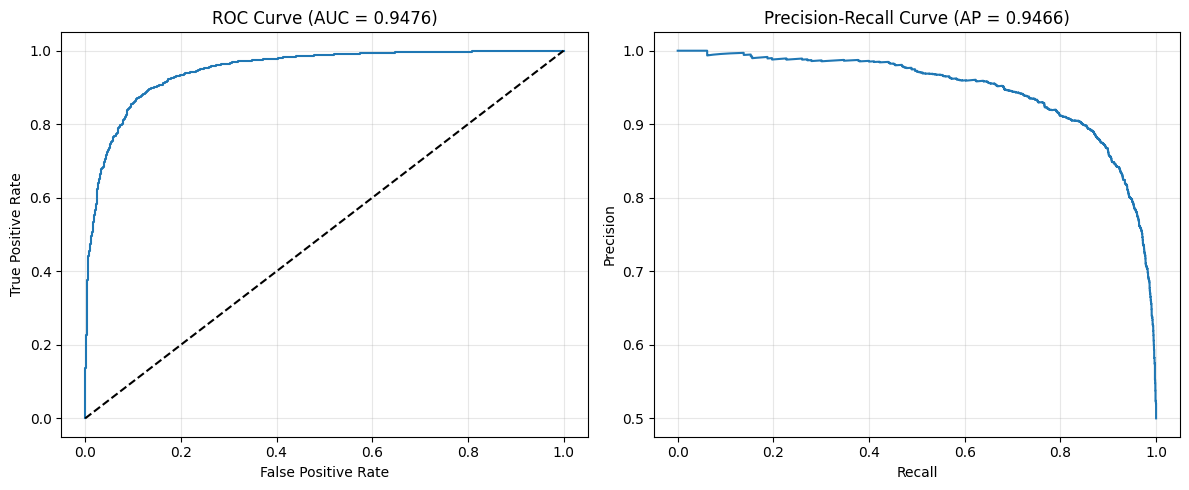

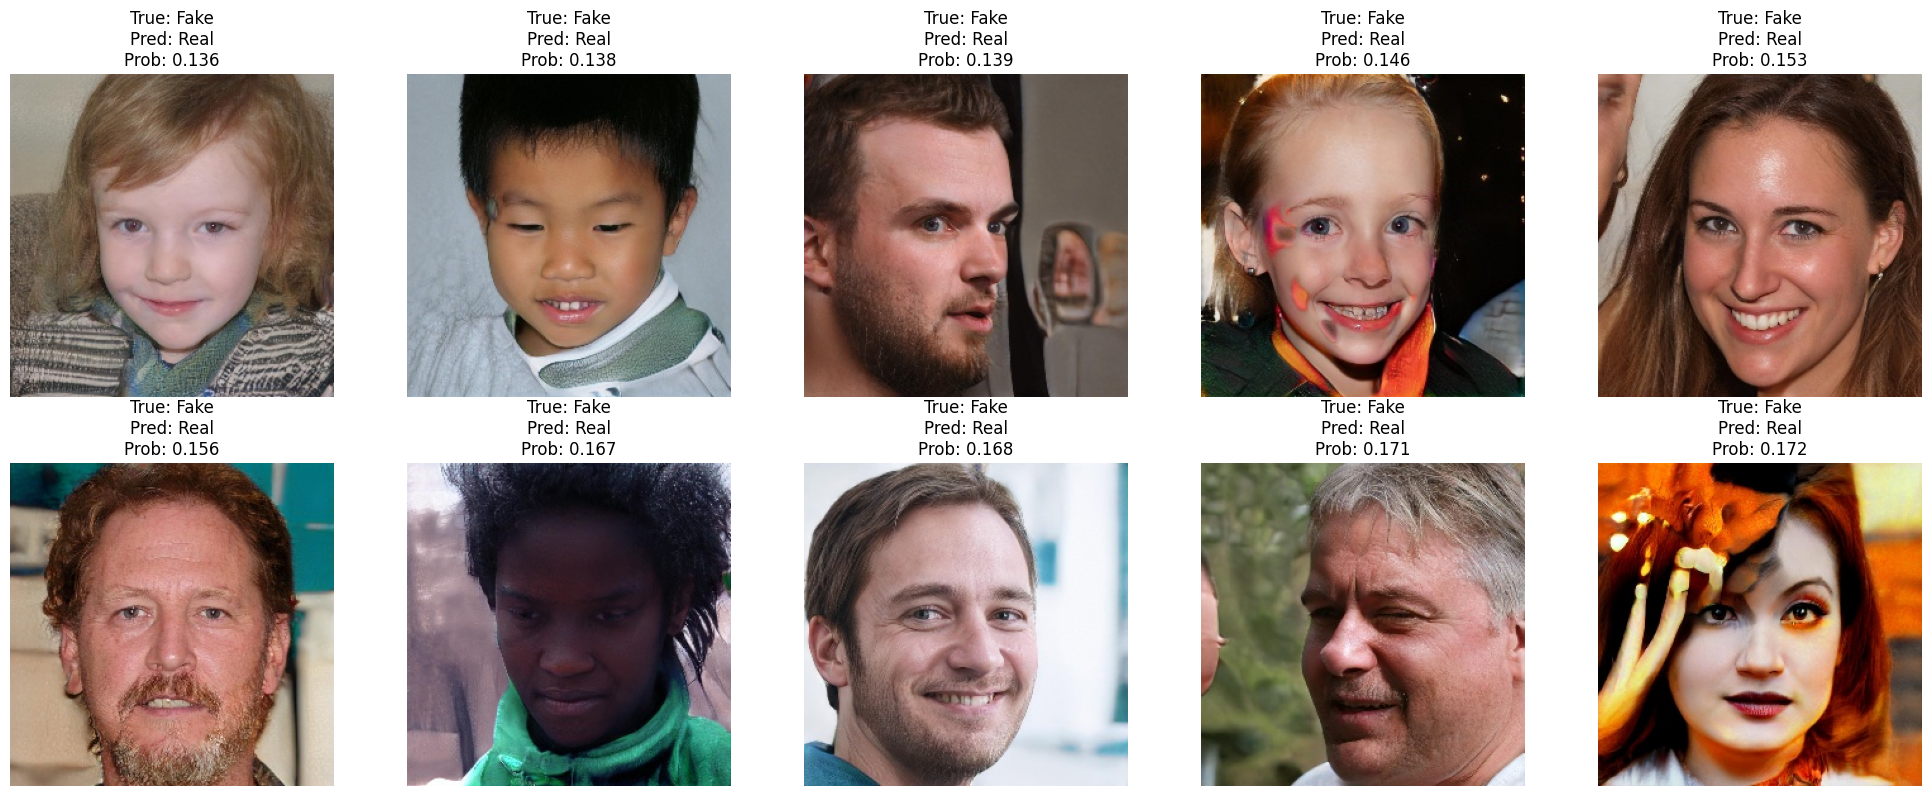


===== HATA ANALİZİ =====
Toplam hata sayısı: 603
Gerçek -> Sahte (False Positive): 296 (49.09%)
Sahte -> Gerçek (False Negative): 307 (50.91%)

Örnek tahminler yapılıyor...
Model başarıyla yüklendi. En iyi doğruluk: 87.10%
Tahmin Olasılıkları -> Real=0.7623, Fake=0.2377
Tahmin Etiketi: Real


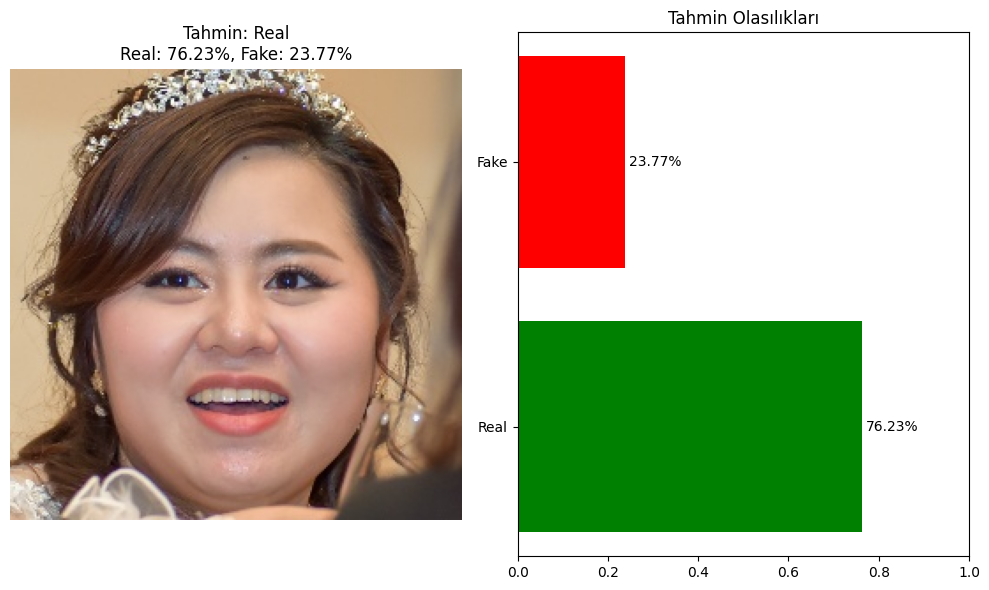

Model başarıyla yüklendi. En iyi doğruluk: 87.10%
Tahmin Olasılıkları -> Real=0.4034, Fake=0.5966
Tahmin Etiketi: Fake


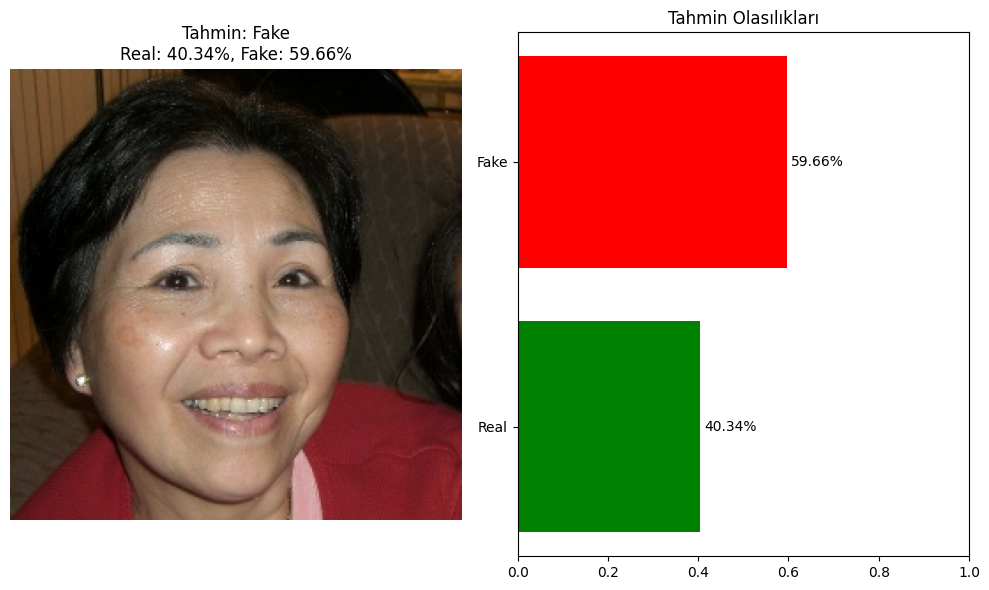

Model başarıyla yüklendi. En iyi doğruluk: 87.10%
Tahmin Olasılıkları -> Real=0.8498, Fake=0.1502
Tahmin Etiketi: Real


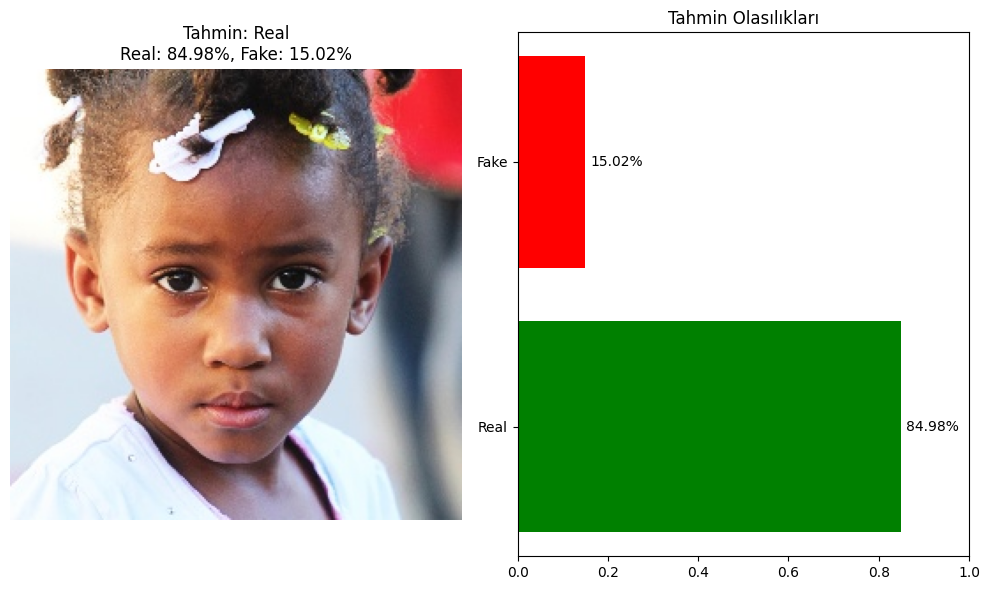

Model başarıyla yüklendi. En iyi doğruluk: 87.10%
Tahmin Olasılıkları -> Real=0.8229, Fake=0.1771
Tahmin Etiketi: Real


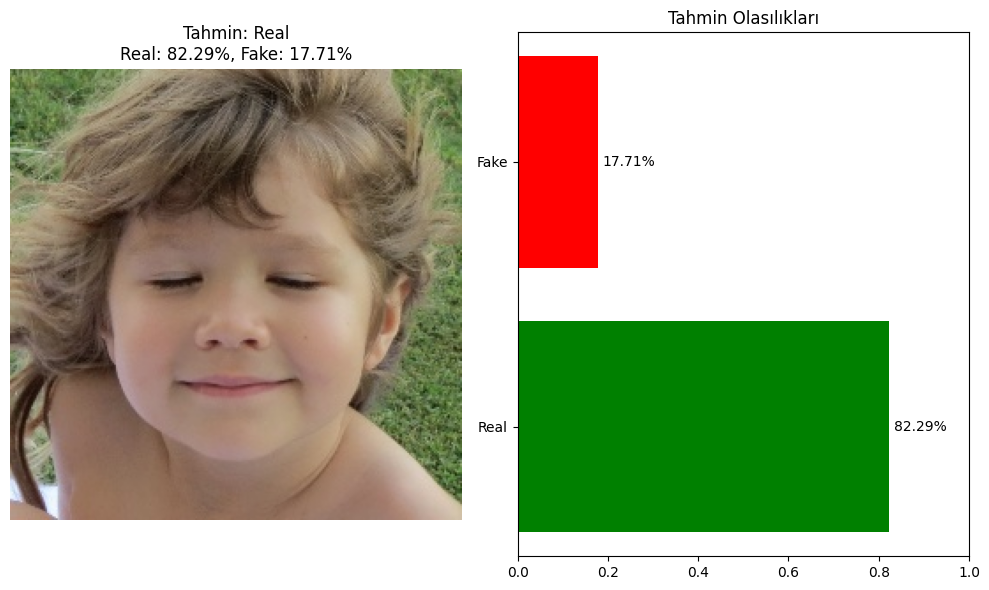

Model başarıyla yüklendi. En iyi doğruluk: 87.10%
Tahmin Olasılıkları -> Real=0.8383, Fake=0.1617
Tahmin Etiketi: Real


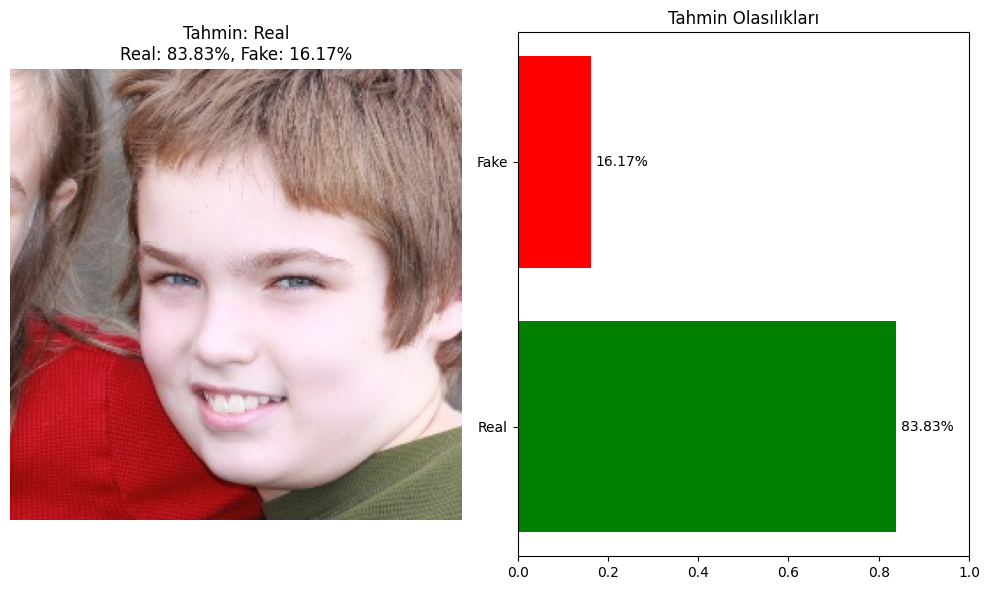


İşlem tamamlandı.


In [100]:
def main():
    print("Yüksek Performanslı DeepFake Tespit Modeli Eğitimi")
    print("=" * 70)
    print(f"Konfigürasyon:")
    print(f"  Dataset: {DATASET_PATH}")
    print(f"  Max Samples: {MAX_SAMPLES}")
    print(f"  Backbone: {BACKBONE}")
    print(f"  Spektral Analiz: {'Aktif' if USE_SPECTRAL else 'Pasif'}")
    print(f"  Attention Mekanizması: {'Aktif' if USE_ATTENTION else 'Pasif'}")
    print(f"  Kademeli Eğitim: {'Aktif' if USE_PROGRESSIVE_TRAINING else 'Pasif'}")
    print(f"  Mixup Augmentation: {'Aktif' if USE_MIXUP else 'Pasif'}")
    print(f"  Learning Rate: {LEARNING_RATE}")
    print(f"  Model Dosyası: {MODEL_SAVE_PATH}")
    print("=" * 70)
    
    # Model eğitimi
    print("\nModeli eğitmeye başlıyorum...")
    
    # Modelimizi eğitelim
    train_model(
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        max_samples=MAX_SAMPLES,
        save_path=MODEL_SAVE_PATH
    )
    
    # Test değerlendirmesi - aynı model dosyasını kullan
    test_model(MODEL_SAVE_PATH)
    
    print("\nİşlem tamamlandı.")

if __name__ == "__main__":
    main()